# Self attention

## Self attention without learning

In [4]:
# Definition of basic functions

# vector addition
def vectorAdd(v1, v2):
    if len(v1) != len(v2):
        raise ValueError("different vector lengths")
    return [v1[i] + v2[i] for i in range(len(v1))]


# vector addition for a list of vectors
def vectorAddList(vectorlist):
    v= vectorlist[0]
    for vi in vectorlist[1:]:
        v = vectorAdd(v, vi)
    return v

# scalar multiplication
def scalarMult(scalar, v):
    return [scalar * v[i] for i in range(len(v))]

# dot product
def dot(v1, v2):
    if len(v1) != len(v2):
        raise ValueError("different vector lengths")
    return sum(v1[i] * v2[i] for i in range(len(v1)))


In [5]:
a= [1,2,3] 
b= [1,0,1]
print("a + b =", vectorAdd(a, b), vectorAddList([a,b]))
print("2*a =", scalarMult(2, a))
print("a . b =", dot(a, b))



a + b = [2, 2, 4] [2, 2, 4]
2*a = [2, 4, 6]
a . b = 4


Softmax Funktion $\sigma$:

$\sigma: \mathbf{R}^K \rightarrow (0,1)^K$ normalisierte Exponentialfunktion mit 

$ \sigma(\vec{x})_i = \frac{e^{x_{i}}}{\sum_{j=1}^K e^{x_{j}}}  \ for\ i=1,2,\dots,K  $



In [6]:
e = 2.718281828459

def softmax(x):
    return [e**x[i] / sum(e**x[j] for j in range(len(x))) for i in range(len(x))]

In [7]:
print(a,"softmax =", softmax(a))
print(b,"softmax =", softmax(b))
print([1,-10,-10],"softmax =", softmax([1,0,0]))
print([4],"softmax =", softmax([4]))



[1, 2, 3] softmax = [0.09003057317038284, 0.24472847105480003, 0.6652409557748171]
[1, 0, 1] softmax = [0.4223187982515171, 0.1553624034969658, 0.4223187982515171]
[1, -10, -10] softmax = [0.576116884765825, 0.21194155761708747, 0.21194155761708747]
[4] softmax = [1.0]


$\alpha$ ist die Relevanzmatrix, die sich aus dem Vergleich der Wortvektoren untereinander ergibt. Sei $L$ die Eingangstextlänge, dann ist

$\alpha_{ij} = softmax(score(x_i,x_j))\ \forall i,j \leq K$ die Relevanzmatrix.

Im Falle von *masked attention* vergleicht man den Wortvektor nur mit den vorangegangenen. Damit ergeben sich für ein Wort $x_i$ die Relevanzwerte:

$\alpha_{ij} = softmax(score(x_i,x_j))\ \forall j \leq i$ 

In [ ]:
def score(x,y):
    return dot(x,y)

def alpha_masked(x): # x ist eine Liste von Wortvektoren
    alpha = []
    for i in range(len(x)):
        row = []
        for j in range(i+1):
            row.append(score(x[i], x[j]))
        alpha.append(softmax(row))
    return alpha

def alpha_masked_matrix(x): # x ist eine Liste von Wortvektoren
    alpha = []
    for i in range(len(x)):
        row = []
        for j in range(len(x)):
            if j <= i:
                row.append(score(x[i], x[j]))
            else:
                row.append(-float('inf'))  # use a large value to represent masked positions
        alpha.append(softmax(row))
    return alpha
    
def alpha(x): # x ist eine Liste von Wortvektoren
    alpha = []
    for i in range(len(x)):
        row = []
        for j in range(len(x)):
            row.append(score(x[i], x[j]))
        alpha.append(softmax(row))
    return alpha


In [9]:
vectorlist = [[2,4], [1,2], [0,2]]
alpha(vectorlist), alpha_masked(vectorlist)

([[0.9999484585145457, 4.539758978267296e-05, 6.143895671497805e-06],
  [0.9908674725821718, 0.006676412513377005, 0.002456114904451198],
  [0.9646631559719018, 0.017668422014049192, 0.017668422014049192]],
 [[1.0],
  [0.9933071490757145, 0.006692850924285412],
  [0.9646631559719018, 0.017668422014049192, 0.017668422014049192]])

Der kontextualisierte Output-Vektor  $y_i$ zu einem Inputvektor $x_i$ gegeben eine Liste von Wortvektoren $[x_j\ j\leq i]$ ist:

$$ y_i = \sum_{j\leq i} \alpha_{i,j} x_j  $$


In [10]:

def contextualized(x): # x ist eine Liste von Wortvektoren
    y = []
    for i in range(len(x)):
        a = alpha_masked(x)
        yi = vectorAddList([scalarMult(a[i][j] ,x[j]) for j in range(i+1)])
        y.append(yi)
    return y
 


In [11]:
contextualized([[1,2], [1,0], [1,1], [2,2]])

[[1.0, 2.0],
 [1.0, 1.0],
 [1.0, 1.5752103826044344],
 [1.8649548767993709, 1.9798697812543224]]

In [74]:
vectorlist = [[2, 4], [1, 2], [2, 0.1]]
vectorlist, contextualized(vectorlist)

([[2, 4], [1, 2], [2, 0.1]],
 [[2.0, 4.0],
  [1.9933071490757144, 3.9866142981514288],
  [1.938024701975659, 2.399131881320575]])

Liste von Wortvektoren: $[[2, 4], [1, 2], [2, 0.1]]$
Detaillierte Berechnung von $$ y_2 = \sum_{j\leq 2} \alpha_{2,j} x_j = \alpha_{2,0} x_0 + \alpha_{2,1} x_1 + \alpha_{2,2} x_2 $$ 
$$ [\alpha_{2,0},\alpha_{2,1},\alpha_{2,2}] = softmax([score(x_2,x_0), score(x_2,x_1), score(x_2,x_2)] )  = \\
softmax([4.4,2.2,4.01]) \approx [0.56,0.06,0.38] $$

**Vorsicht**: Der Vektor [2,0.1] hat ein höheres dot-Produkt mit dem Vektor [2,4] als mit sich selbst. Dies widerspricht der Idee, dass das dot-Produkt hier Ähnlichkeit modellieren soll. Ein Ausweg ist die explizite L2-Normalisierung der Wort-Embeddings:
Bevor das Dot-Produkt zur Berechnung von Relevanz-Scores verwendet wird, werden die Wortvektoren (Embeddings) explizit auf die Länge 1 normiert.

Statt einem Vektor $u$ wird der Vektor $\frac{u}{\|u\|}$ genutzt. Damit wird das dot-Produkt zur Cosinus-Ähnlichkeit: 
$$\text{cosine\_similarity}(u, v) = \frac{u \cdot v}{\|u\| \cdot \|v\|}$$

Hier werden wir dieses Problem erst einmal vernachlässigen.

In [75]:
w1 = "each"
wa2 = "session"
wb2 = "person"
w3 = "has"
w4 = "a"
w5 = "chair"



v1 = [4,3,3]
va2 = [7,2,1]
vb2 = [1,2,7]
v3 = [3.5,3,3.5]
v4 = [3,3,4]
v5 = [3,4,3]

s1 = [w1, wa2, w3, w4, w5]
s2 = [w1, wb2, w3, w4, w5]
vs1 = [v1, va2, v3, v4, v5]
vs2 = [v1, vb2, v3, v4, v5]

print("Focus: embedding of '{}'".format(w5))

print("uncontextualized embedding of", w5, "is", v5) 
print("uncontextualized embedding of", wa2, "is", va2) 
print("uncontextualized embedding of", wb2, "is", vb2) 
print("\ncontextualized embedding of", w5, "in", s1, "is")
print(contextualized(vs1)[4])
print("\ncontextualized embedding of", w5, "in", s2, "is")
print(contextualized(vs2)[4])



Focus: embedding of 'chair'
uncontextualized embedding of chair is [3, 4, 3]
uncontextualized embedding of session is [7, 2, 1]
uncontextualized embedding of person is [1, 2, 7]

contextualized embedding of chair in ['each', 'session', 'has', 'a', 'chair'] is
[3.488241706560337, 3.3861879899594367, 3.1255703034802282]

contextualized embedding of chair in ['each', 'person', 'has', 'a', 'chair'] is
[3.1255703034802282, 3.3861879899594367, 3.4882417065603373]


## Self attention with learning

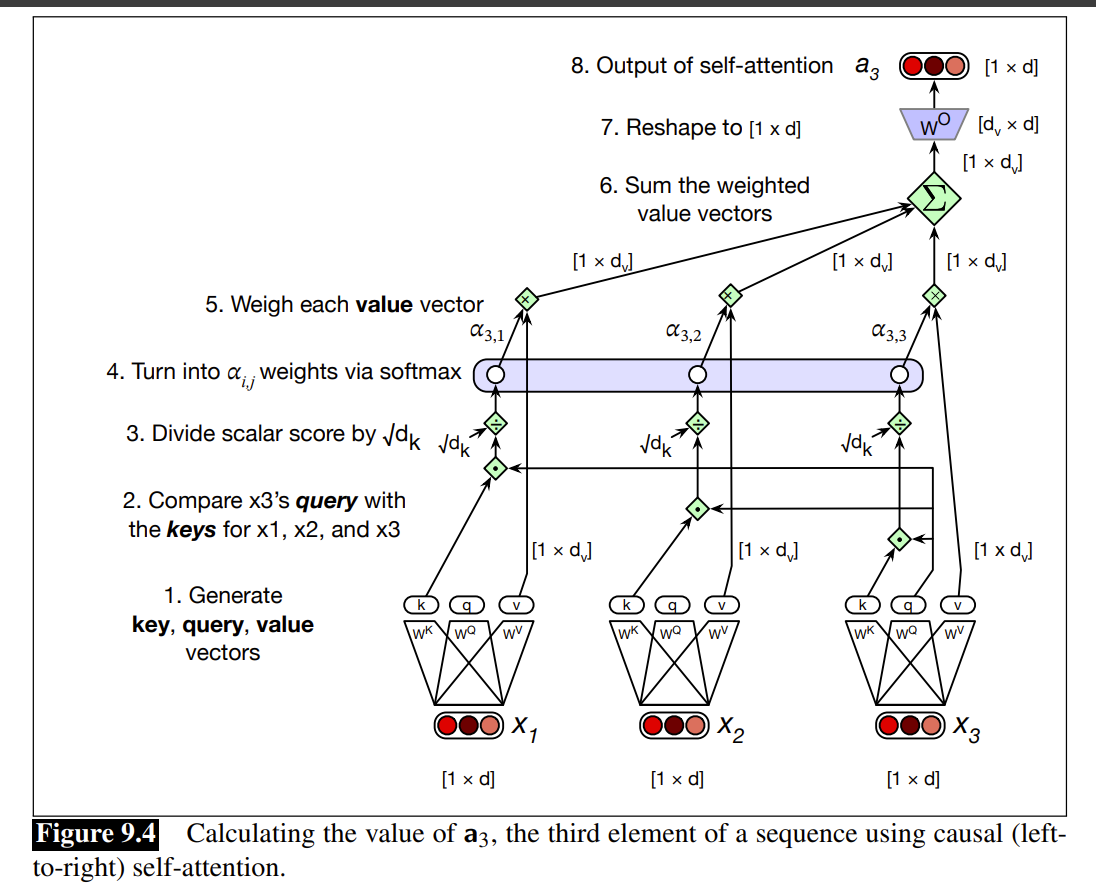

<img src="JM_9_4.png" width="500"> Bild aus Jurafsky & Martin (3rd edition, draft, January 12, 2025 release)

![JurafskyMartinImage9.4][JM_image9.4.png]


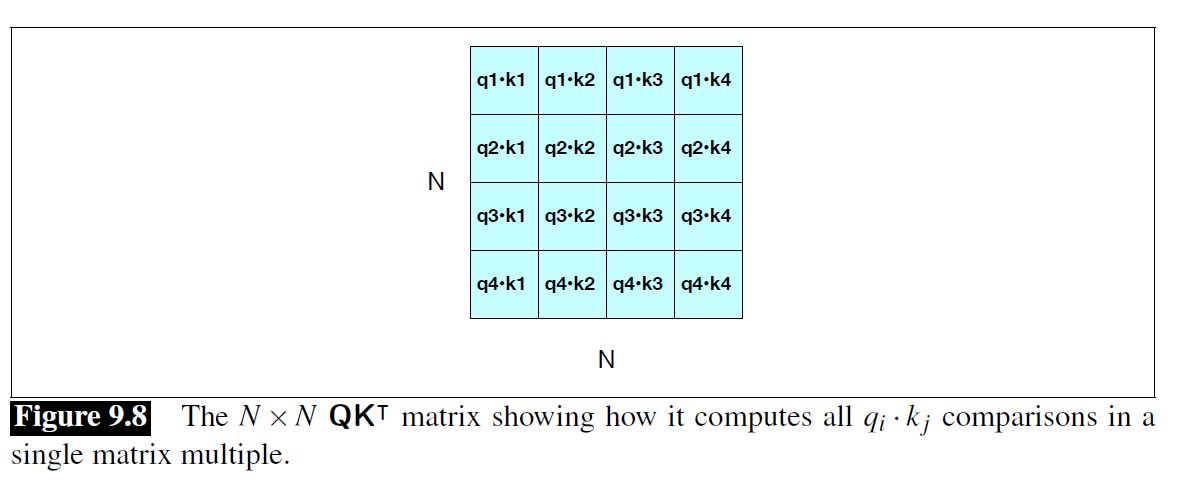